In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scipy
import numpy as np 
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from glob import glob
from albumentations.pytorch import ToTensorV2
from utils.sort_filename import natural_keys
from utils.visualize import show_landmark

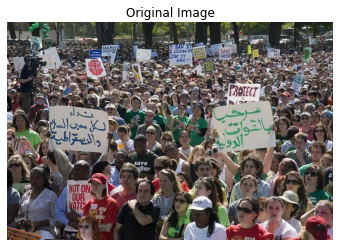

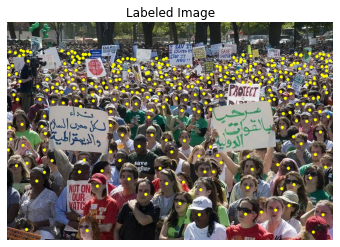

In [3]:
df = pd.read_csv("data/ShanghaiTech/part_A/test_data/data.csv")
idx = 2
img = cv2.cvtColor(cv2.imread(df['image'].iloc[idx]), cv2.COLOR_BGR2RGB)
label = loadmat(df['label'].iloc[idx])['image_info'][0][0][0][0][0].astype(int)

plt.title("Original Image")
plt.imshow(img)
plt.axis(False)
plt.show()

### Put Landmark on the image
circle_option = {'radius':3, 'color':(255, 255, 0), 'thickness':-1}
new_img = show_landmark(img, label, circle_option)
plt.title("Labeled Image")
plt.imshow(new_img)
plt.axis(False)
plt.show()

# Make Grid Image

In [4]:
def reshape_split(image, kernel_size):
  img_height, img_width, channels = image.shape
  tile_height, tile_width = kernel_size

  tiled_array = image.reshape(img_height // tile_height,
                              tile_height, 
                              img_width // tile_width,
                              tile_width,
                              channels)
  tiled_array = tiled_array.swapaxes(1, 2)
  return tiled_array

In [5]:
img.shape

(427, 640, 3)

In [6]:
label.max(axis=0)

array([634, 411])

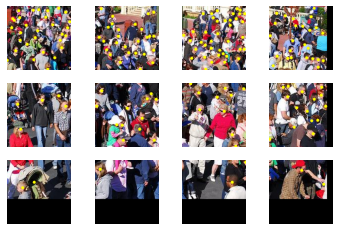

In [10]:
df = pd.read_csv("data/ShanghaiTech/part_A/test_data/data.csv")
idx = 3
img = cv2.cvtColor(cv2.imread(df['image'].iloc[idx]), cv2.COLOR_BGR2RGB)
label = loadmat(df['label'].iloc[idx])['image_info'][0][0][0][0][0].astype(int)
img_pad = cv2.copyMakeBorder(img, 0, 128 - (img.shape[0] % 128), 0, 128 - (img.shape[1] % 128), cv2.BORDER_CONSTANT, (0,0,0))
grid_img = reshape_split(img_pad, (128, 128))

yv, xv = np.meshgrid(np.arange(img_pad.shape[1]+1, step=128), np.arange(img_pad.shape[0]+1, step=128))
circle_option = {'radius':3, 'color':(255, 255, 0), 'thickness':-1}

fig, ax = plt.subplots(nrows=grid_img.shape[0], ncols=grid_img.shape[1])

for row in range(grid_img.shape[0]):
  for col in range(grid_img.shape[1]):
    # x_start, x_stop = xv[row, col], xv[row+1, col+1]
    # y_start, y_stop = yv[row, col], yv[row+1, col+1]
    x_start, x_stop = 128 * row, 128 * (row+1)
    y_start, y_stop = 128 * col, 128 * (col+1)

    check_x = (x_start <= label[:, 1]) & (label[:, 1] < x_stop)
    check_y = (y_start <= label[:, 0]) & (label[:, 0] < y_stop)
    valid_idx = check_x & check_y
    label_grid = label[valid_idx] - np.array([[y_start, x_start]])
    
    new_img = show_landmark(grid_img[row, col], label_grid, circle_option)
    ax[row][col].imshow(new_img)
    ax[row][col].axis(False)

In [11]:
grid_img.shape

(6, 9, 128, 128, 3)

In [9]:
yv.shape, xv.shape

((5, 7), (5, 7))